In [75]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns

from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from catboost import CatBoostClassifier

In [76]:
basic_data = pd.read_csv('CAX_MortgageModeling_Train.csv', index_col='Unique_ID').drop(columns=['MORTGAGE NUMBER'])
competition_data = pd.read_csv('CAX_MortgageModeling_Test.csv', index_col='Unique_ID').drop(columns=['MORTGAGE NUMBER'])

In [77]:
competition_result = pd.read_csv('CAX_MortgageModeling_SubmissionFormat.csv', index_col='Unique_ID')

# Feature engineering

## Income type

In [78]:
basic_data['INCOME TYPE'] = basic_data['INCOME TYPE'].astype(str).dtype

In [79]:
competition_data['INCOME TYPE'] = competition_data['INCOME TYPE'].astype(str).dtype

## Postal Code

In [80]:
FSA_counted = basic_data['FSA'].value_counts()
n = 5
print(f'Type of FSA with less than {n} occurences {len(FSA_counted[FSA_counted < n])}.')

Type of FSA with less than 5 occurences 293.


In [81]:
basic_data['FSA GENERAL'] = basic_data['FSA'].apply(lambda code: code[0])

In [82]:
competition_data['FSA GENERAL'] = competition_data['FSA'].apply(lambda code: code[0] if type(code)==str else None)

## Property type

In [83]:
property_type_mapper = {
    'Duplex': 'Multi-family building',
    'Triplex': 'Multi-family building',
    'Fourplex': 'Multi-family building',
    'Townhouse Freehold': 'Townhouse',
    'Townhouse Condominium': 'Townhouse',
}

In [84]:
basic_data['PROPERTY TYPE'] = basic_data['PROPERTY TYPE'].replace(property_type_mapper)

In [85]:
basic_data['PROPERTY TYPE'].value_counts()

Single Detached          29377
High Rise                 5909
Townhouse                 5349
Semi-Detached             4227
Multi-family building      780
Name: PROPERTY TYPE, dtype: int64

# Null values

In [86]:
basic_data.isnull().any()

PROPERTY VALUE       False
MORTGAGE PAYMENT     False
GDS                  False
LTV                  False
TDS                  False
AMORTIZATION         False
MORTGAGE AMOUNT      False
RATE                 False
MORTGAGE PURPOSE     False
PAYMENT FREQUENCY    False
PROPERTY TYPE        False
TERM                 False
FSA                  False
AGE RANGE            False
GENDER               False
INCOME               False
INCOME TYPE          False
NAICS CODE           False
CREDIT SCORE         False
RESULT               False
FSA GENERAL          False
dtype: bool

In [87]:
competition_data.isnull().any()

PROPERTY VALUE       False
MORTGAGE PAYMENT     False
GDS                  False
LTV                  False
TDS                  False
AMORTIZATION         False
MORTGAGE AMOUNT      False
RATE                 False
MORTGAGE PURPOSE     False
PAYMENT FREQUENCY    False
PROPERTY TYPE        False
TERM                 False
FSA                  False
AGE RANGE            False
GENDER               False
INCOME               False
INCOME TYPE          False
NAICS CODE           False
CREDIT SCORE         False
RESULT                True
FSA GENERAL          False
dtype: bool

### Conclusion: No null values.

# Label Encoding

# Target encoding

In [88]:
def find_smooth_parameter(train_df):
    calc_m_list = list()
    for cat_col in train_df.select_dtypes('O'):
        df = train_df.groupby(cat_col)
        mean_col = train_df[cat_col].value_counts().values.mean()
        calc_m_list.append(mean_col)
    return int(min(calc_m_list))

In [89]:
def calc_smooth_mean(df, cat_column, target_column, m):
    # Compute the global mean
    mean = df[target_column].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(cat_column)[target_column].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    
    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)
    
    # Replace each value by the according smoothed mean
    return df[cat_column].map(smooth), smooth

### Basic dataset

In [90]:
basic_data['RESULT'] = basic_data['RESULT'].map({'FUNDED': 1, 'NOT FUNDED': 0})

In [91]:
categorical_headers = basic_data.drop(columns=[column for column in basic_data._get_numeric_data().columns]).columns
encoders = {}
m = find_smooth_parameter(basic_data)
for column in categorical_headers:
    basic_data[column], encoders[column] = calc_smooth_mean(basic_data, column, 'RESULT', m)

In [92]:
encoders['UNKNOWN'] = (basic_data.shape[0]*basic_data['RESULT'].mean()+m*basic_data['RESULT'].mean())/(basic_data.shape[0]*basic_data['RESULT'].mean())

### Competition dataset

In [93]:
categorical_headers = competition_data.drop(
    columns=[column for column in competition_data._get_numeric_data().columns]
).columns

for column in categorical_headers:
    competition_data[column] = competition_data[column] \
        .map(
            encoders[column]
        ) \
        .replace(
            {np.nan: encoders['UNKNOWN']}
        )


# Correlation

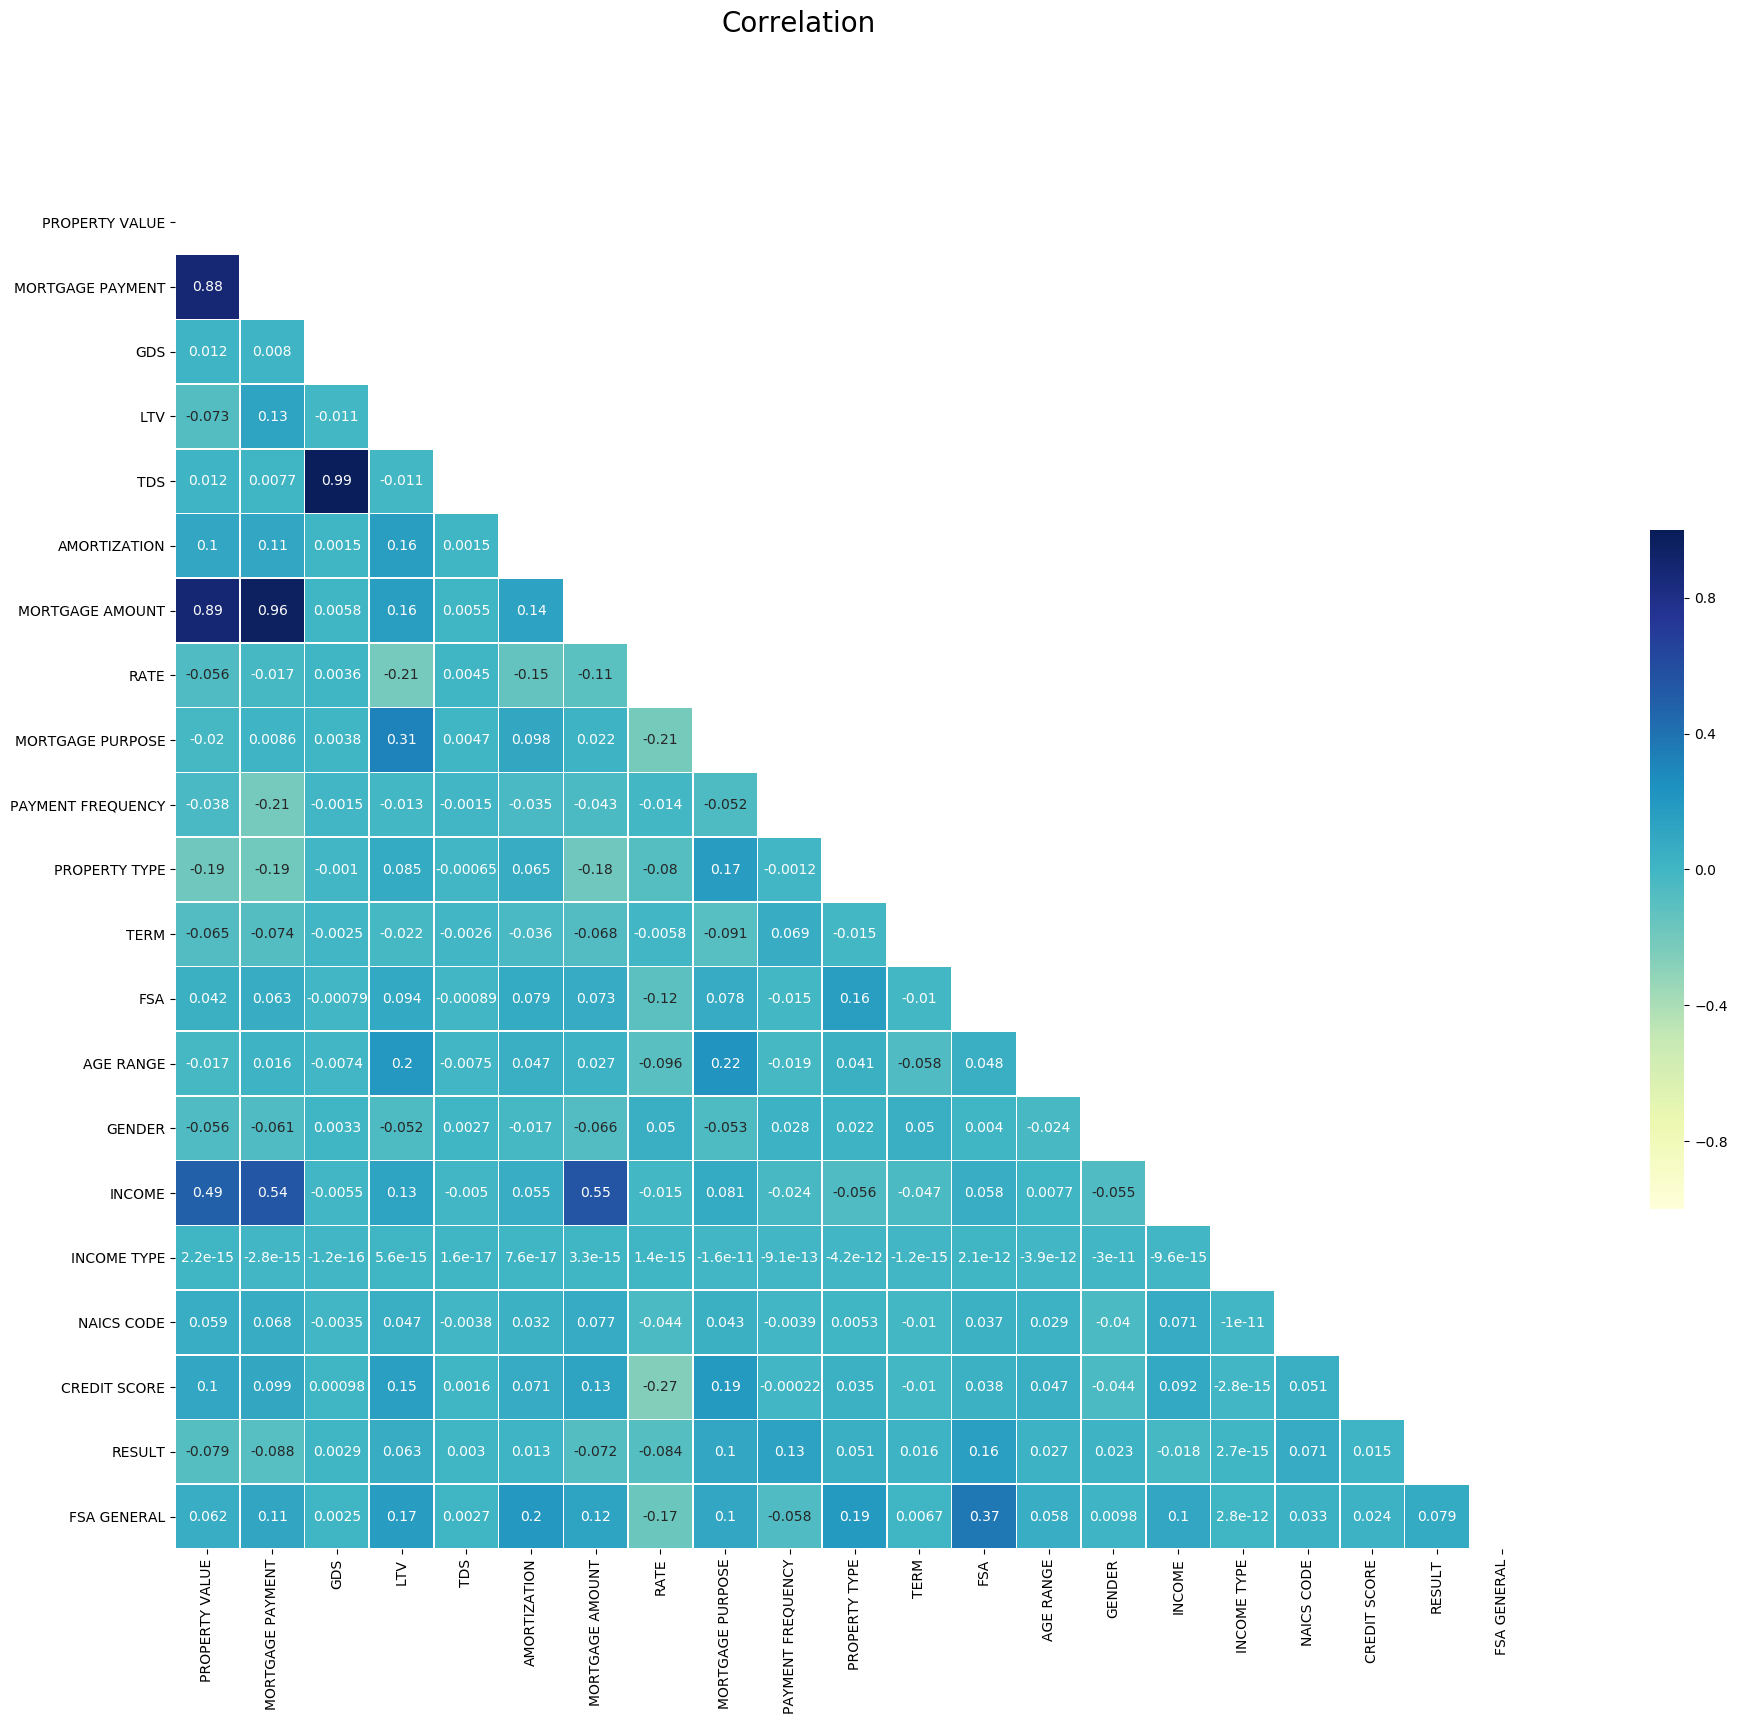

In [94]:
corr = basic_data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f = plt.figure(figsize=(30, 18), dpi=100)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap="YlGnBu", center=0, vmax=1, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
f.suptitle('Correlation', fontsize=20)
plt.savefig('correlation.png')


### Conclusion: 
Based on corelation I can drop:
- GDS
- PROPERTY VALUE
- MOTRAGE PAYMENT

In [95]:
basic_data = basic_data.drop(columns = ['GDS', 'PROPERTY VALUE', 'MORTGAGE PAYMENT'])
competition_data = competition_data.drop(columns = ['GDS', 'PROPERTY VALUE', 'MORTGAGE PAYMENT'])

# Split data

In [96]:
X_train, X_test, y_train, y_test = train_test_split(
    basic_data.drop(columns=['RESULT']), 
    basic_data['RESULT'],
    test_size=0.2,
)

In [97]:
X_test.shape

(9129, 17)

# Imbalanced data

In [157]:
not_funded_ratio = round(y_train.value_counts()[0]/(y_train.value_counts()[1]+y_train.value_counts()[0])*100)
funded_ratio = 100 - not_funded_ratio
print(f'Funded {funded_ratio}% \nNot funded {not_funded_ratio}% \nof training dataset.')

Funded 79.0% 
Not funded 21.0% 
of training dataset.


In [158]:
test_data = X_train.join(y_train)
funded_data = test_data[test_data['RESULT']==1]
not_funded_data = test_data[test_data['RESULT']==0]

## Downsampling

In [109]:
funded_data_downsampled = resample(
    funded_data, 
    replace = False, # sample without replacement
    n_samples = len(not_funded_data), # match minority n
    random_state = 27
)

# combine minority and downsampled majority
test_data_downsampled = pd.concat([funded_data_downsampled, not_funded_data])

X_train = test_data_downsampled.drop(columns=['RESULT'])
y_train = test_data_downsampled['RESULT']

### Plot confusion matrix

In [98]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    print("Confusion matrix")
    print(cm)
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# XGBoost fitting

### Randomized search

In [403]:
hyper_params = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'max_depth': [int(i) for i in np.linspace(10, 50, 41)],
    'subsample': [i for i in np.linspace(0.1, 1, 21)],
    'colsample_bytree': [i for i in np.linspace(1, 1, 20)],
    'n_estimators': [int(i) for i in np.linspace(100, 500, 401)],
    'alpha': [int(i) for i in np.linspace(10, 50, 41)]
}

In [404]:
xgb_clf = xgb.XGBClassifier(objective ='binary:logistic')
randomized_search = RandomizedSearchCV(xgb_clf, hyper_params, verbose=100, n_iter=30, scoring='f1_macro', cv=4)

In [405]:
randomized_search.fit(X_train, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] subsample=0.37, n_estimators=105, max_depth=43, learning_rate=0.001, colsample_bytree=1.0, alpha=24 
[CV]  subsample=0.37, n_estimators=105, max_depth=43, learning_rate=0.001, colsample_bytree=1.0, alpha=24, score=0.5251147987974426, total=  21.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.9s remaining:    0.0s
[CV] subsample=0.37, n_estimators=105, max_depth=43, learning_rate=0.001, colsample_bytree=1.0, alpha=24 
[CV]  subsample=0.37, n_estimators=105, max_depth=43, learning_rate=0.001, colsample_bytree=1.0, alpha=24, score=0.5335969075859277, total=  20.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   43.7s remaining:    0.0s
[CV] subsample=0.37, n_estimators=105, max_depth=43, learning_rate=0.001, colsample_bytree=1.0, alpha=24 
[CV]  subsample=0.37, n_estimators=105, max_depth=43, learning_rate=0.001, colsample_

[CV]  subsample=0.9099999999999999, n_estimators=114, max_depth=25, learning_rate=0.01, colsample_bytree=1.0, alpha=44, score=0.5514558897717241, total=  33.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 24.5min remaining:    0.0s
[CV] subsample=0.9099999999999999, n_estimators=114, max_depth=25, learning_rate=0.01, colsample_bytree=1.0, alpha=44 
[CV]  subsample=0.9099999999999999, n_estimators=114, max_depth=25, learning_rate=0.01, colsample_bytree=1.0, alpha=44, score=0.5527655714037298, total=  35.3s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed: 25.1min remaining:    0.0s
[CV] subsample=0.9099999999999999, n_estimators=114, max_depth=25, learning_rate=0.01, colsample_bytree=1.0, alpha=44 
[CV]  subsample=0.9099999999999999, n_estimators=114, max_depth=25, learning_rate=0.01, colsample_bytree=1.0, alpha=44, score=0.5576859291690506, total=  33.4s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 25.7min remaining:    0.0s
[CV] subsample=0.9099999999999999, n_estim

[CV]  subsample=0.505, n_estimators=400, max_depth=46, learning_rate=0.05, colsample_bytree=1.0, alpha=15, score=0.562790885139187, total= 1.6min
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed: 50.9min remaining:    0.0s
[CV] subsample=0.505, n_estimators=400, max_depth=46, learning_rate=0.05, colsample_bytree=1.0, alpha=15 
[CV]  subsample=0.505, n_estimators=400, max_depth=46, learning_rate=0.05, colsample_bytree=1.0, alpha=15, score=0.5673449403448083, total= 1.7min
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 52.8min remaining:    0.0s
[CV] subsample=0.505, n_estimators=400, max_depth=46, learning_rate=0.05, colsample_bytree=1.0, alpha=15 
[CV]  subsample=0.505, n_estimators=400, max_depth=46, learning_rate=0.05, colsample_bytree=1.0, alpha=15, score=0.56942929032927, total= 1.6min
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed: 54.6min remaining:    0.0s
[CV] subsample=0.505, n_estimators=400, max_depth=46, learning_rate=0.05, colsample_bytree=1.0, alpha=15 
[CV]

[CV]  subsample=0.6849999999999999, n_estimators=225, max_depth=14, learning_rate=0.05, colsample_bytree=1.0, alpha=18, score=0.5681304949727879, total=  34.1s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed: 86.2min remaining:    0.0s
[CV] subsample=0.6849999999999999, n_estimators=225, max_depth=14, learning_rate=0.05, colsample_bytree=1.0, alpha=18 
[CV]  subsample=0.6849999999999999, n_estimators=225, max_depth=14, learning_rate=0.05, colsample_bytree=1.0, alpha=18, score=0.5671191464278761, total=  33.4s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 86.8min remaining:    0.0s
[CV] subsample=0.6849999999999999, n_estimators=225, max_depth=14, learning_rate=0.05, colsample_bytree=1.0, alpha=18 
[CV]  subsample=0.6849999999999999, n_estimators=225, max_depth=14, learning_rate=0.05, colsample_bytree=1.0, alpha=18, score=0.5734079820619447, total=  33.3s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed: 87.4min remaining:    0.0s
[CV] subsample=0.7749999999999999, n_estim

[CV]  subsample=0.865, n_estimators=471, max_depth=25, learning_rate=0.005, colsample_bytree=1.0, alpha=14, score=0.5471383528818262, total= 2.1min
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed: 109.2min remaining:    0.0s
[CV] subsample=0.865, n_estimators=471, max_depth=25, learning_rate=0.005, colsample_bytree=1.0, alpha=14 
[CV]  subsample=0.865, n_estimators=471, max_depth=25, learning_rate=0.005, colsample_bytree=1.0, alpha=14, score=0.5611278090556273, total= 2.1min
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed: 111.6min remaining:    0.0s
[CV] subsample=0.865, n_estimators=471, max_depth=25, learning_rate=0.005, colsample_bytree=1.0, alpha=14 
[CV]  subsample=0.865, n_estimators=471, max_depth=25, learning_rate=0.005, colsample_bytree=1.0, alpha=14, score=0.5521068223181929, total= 2.0min
[CV] subsample=0.5499999999999999, n_estimators=409, max_depth=30, learning_rate=0.1, colsample_bytree=1.0, alpha=26 
[CV]  subsample=0.5499999999999999, n_estimators=409, max_dept

RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=30, n_jobs=None,
          param_distributions={'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1], 'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 'subsample': [0.1, 0.14500000000000002, 0.19, 0.23...26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]},
          pre_dispatch='2*n_jobs', random_state=None, r

In [406]:
randomized_search.best_params_ 

{'subsample': 0.5499999999999999,
 'n_estimators': 298,
 'max_depth': 15,
 'learning_rate': 0.1,
 'colsample_bytree': 1.0,
 'alpha': 14}

### Fitting model

In [110]:
xgb_clf = xgb.XGBClassifier(
    objective ='binary:logistic', 
    subsample=0.55,
    n_estimators=298,
    max_depth=15,
    learning_rate=0.1,
    colsample_bytree=1.0,
    alpha=14
)

In [111]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=14, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1.0, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=15,
       min_child_weight=1, missing=None, n_estimators=298, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.55, verbosity=1)

### Predict probability

In [112]:
y_pred_xgb_prob = xgb_clf.predict_proba(X_test)
y_pred_prob_xgb_funded= list(map(lambda x: x, [value[1] for value in y_pred_xgb_prob]))

In [113]:
fpr, tpr, treshold = roc_curve(y_test, y_pred_prob_xgb_funded)

In [114]:
score = f1_score(
    y_test, 
    list(map(lambda x: 1 if x > np.mean(treshold) else 0, y_pred_prob_xgb_funded)), 
    average='macro'
)
print(f'F1 score: {score}')

F1 score: 0.6079153306341003


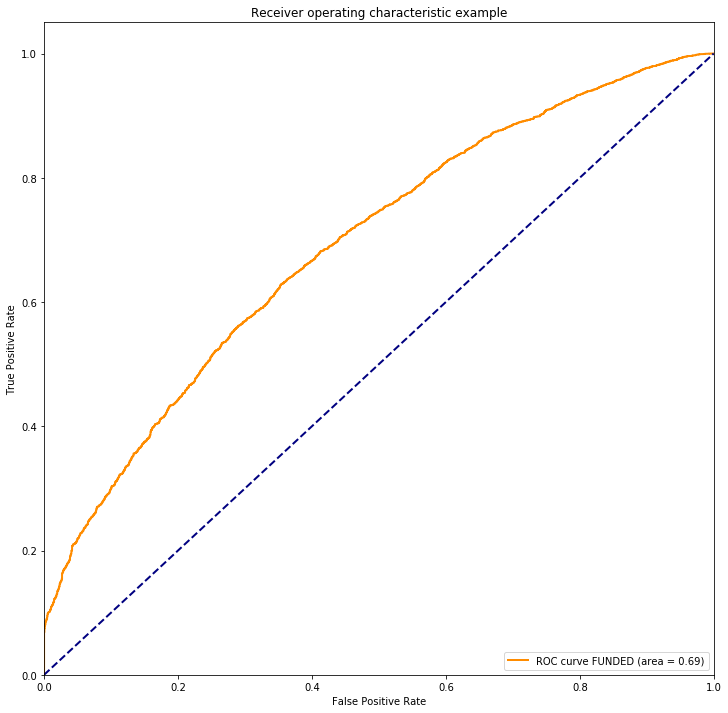

In [115]:
plt.figure(figsize=(12,12))

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve FUNDED (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('xgboost_roc.png')

# CatBoost

In [116]:
catboost_clf = CatBoostClassifier(
)

In [117]:
catboost_clf.fit(X_train, y_train, eval_set=(X_test, y_test))

Learning rate set to 0.113844
0:	learn: 0.6359936	test: 0.6355404	best: 0.6355404 (0)	total: 232ms	remaining: 3m 51s
1:	learn: 0.5960266	test: 0.5957375	best: 0.5957375 (1)	total: 395ms	remaining: 3m 16s
2:	learn: 0.5707235	test: 0.5706587	best: 0.5706587 (2)	total: 593ms	remaining: 3m 17s
3:	learn: 0.5510387	test: 0.5513357	best: 0.5513357 (3)	total: 725ms	remaining: 3m
4:	learn: 0.5354001	test: 0.5360767	best: 0.5360767 (4)	total: 841ms	remaining: 2m 47s
5:	learn: 0.5224854	test: 0.5233149	best: 0.5233149 (5)	total: 937ms	remaining: 2m 35s
6:	learn: 0.5124454	test: 0.5139130	best: 0.5139130 (6)	total: 1.05s	remaining: 2m 28s
7:	learn: 0.5049360	test: 0.5066213	best: 0.5066213 (7)	total: 1.15s	remaining: 2m 22s
8:	learn: 0.4968331	test: 0.4987887	best: 0.4987887 (8)	total: 1.24s	remaining: 2m 16s
9:	learn: 0.4905736	test: 0.4924971	best: 0.4924971 (9)	total: 1.35s	remaining: 2m 13s
10:	learn: 0.4866179	test: 0.4887677	best: 0.4887677 (10)	total: 1.46s	remaining: 2m 11s
11:	learn: 0.48

93:	learn: 0.4497558	test: 0.4619161	best: 0.4619161 (93)	total: 10.8s	remaining: 1m 44s
94:	learn: 0.4494854	test: 0.4617166	best: 0.4617166 (94)	total: 10.9s	remaining: 1m 44s
95:	learn: 0.4494235	test: 0.4616659	best: 0.4616659 (95)	total: 11s	remaining: 1m 43s
96:	learn: 0.4493626	test: 0.4616498	best: 0.4616498 (96)	total: 11.1s	remaining: 1m 43s
97:	learn: 0.4493076	test: 0.4616525	best: 0.4616498 (96)	total: 11.3s	remaining: 1m 43s
98:	learn: 0.4490401	test: 0.4615685	best: 0.4615685 (98)	total: 11.4s	remaining: 1m 43s
99:	learn: 0.4489133	test: 0.4616014	best: 0.4615685 (98)	total: 11.5s	remaining: 1m 43s
100:	learn: 0.4489058	test: 0.4616162	best: 0.4615685 (98)	total: 11.6s	remaining: 1m 43s
101:	learn: 0.4487911	test: 0.4615075	best: 0.4615075 (101)	total: 11.7s	remaining: 1m 42s
102:	learn: 0.4487408	test: 0.4614879	best: 0.4614879 (102)	total: 11.8s	remaining: 1m 42s
103:	learn: 0.4487200	test: 0.4614773	best: 0.4614773 (103)	total: 11.9s	remaining: 1m 42s
104:	learn: 0.44

185:	learn: 0.4400478	test: 0.4592227	best: 0.4592019 (183)	total: 20.7s	remaining: 1m 30s
186:	learn: 0.4400195	test: 0.4592154	best: 0.4592019 (183)	total: 20.9s	remaining: 1m 30s
187:	learn: 0.4400163	test: 0.4592178	best: 0.4592019 (183)	total: 21s	remaining: 1m 30s
188:	learn: 0.4399156	test: 0.4591627	best: 0.4591627 (188)	total: 21.1s	remaining: 1m 30s
189:	learn: 0.4399141	test: 0.4591676	best: 0.4591627 (188)	total: 21.2s	remaining: 1m 30s
190:	learn: 0.4396944	test: 0.4589108	best: 0.4589108 (190)	total: 21.3s	remaining: 1m 30s
191:	learn: 0.4395079	test: 0.4587439	best: 0.4587439 (191)	total: 21.4s	remaining: 1m 30s
192:	learn: 0.4394680	test: 0.4587611	best: 0.4587439 (191)	total: 21.5s	remaining: 1m 30s
193:	learn: 0.4393051	test: 0.4586620	best: 0.4586620 (193)	total: 21.7s	remaining: 1m 29s
194:	learn: 0.4392315	test: 0.4586529	best: 0.4586529 (194)	total: 21.8s	remaining: 1m 29s
195:	learn: 0.4391944	test: 0.4586445	best: 0.4586445 (195)	total: 21.9s	remaining: 1m 29s
1

276:	learn: 0.4347262	test: 0.4577317	best: 0.4577317 (276)	total: 30.6s	remaining: 1m 19s
277:	learn: 0.4347247	test: 0.4577367	best: 0.4577317 (276)	total: 30.7s	remaining: 1m 19s
278:	learn: 0.4345662	test: 0.4577521	best: 0.4577317 (276)	total: 30.9s	remaining: 1m 19s
279:	learn: 0.4345400	test: 0.4577443	best: 0.4577317 (276)	total: 31s	remaining: 1m 19s
280:	learn: 0.4345375	test: 0.4577442	best: 0.4577317 (276)	total: 31.1s	remaining: 1m 19s
281:	learn: 0.4343178	test: 0.4577717	best: 0.4577317 (276)	total: 31.2s	remaining: 1m 19s
282:	learn: 0.4343115	test: 0.4577672	best: 0.4577317 (276)	total: 31.3s	remaining: 1m 19s
283:	learn: 0.4343113	test: 0.4577699	best: 0.4577317 (276)	total: 31.4s	remaining: 1m 19s
284:	learn: 0.4343105	test: 0.4577720	best: 0.4577317 (276)	total: 31.5s	remaining: 1m 19s
285:	learn: 0.4341180	test: 0.4578151	best: 0.4577317 (276)	total: 31.6s	remaining: 1m 18s
286:	learn: 0.4341097	test: 0.4578292	best: 0.4577317 (276)	total: 31.8s	remaining: 1m 18s
2

368:	learn: 0.4311764	test: 0.4575514	best: 0.4573550 (337)	total: 41.9s	remaining: 1m 11s
369:	learn: 0.4310993	test: 0.4575963	best: 0.4573550 (337)	total: 42s	remaining: 1m 11s
370:	learn: 0.4309988	test: 0.4575557	best: 0.4573550 (337)	total: 42.2s	remaining: 1m 11s
371:	learn: 0.4309189	test: 0.4575792	best: 0.4573550 (337)	total: 42.3s	remaining: 1m 11s
372:	learn: 0.4307899	test: 0.4575408	best: 0.4573550 (337)	total: 42.4s	remaining: 1m 11s
373:	learn: 0.4307508	test: 0.4575252	best: 0.4573550 (337)	total: 42.5s	remaining: 1m 11s
374:	learn: 0.4306612	test: 0.4575396	best: 0.4573550 (337)	total: 42.6s	remaining: 1m 11s
375:	learn: 0.4306547	test: 0.4575525	best: 0.4573550 (337)	total: 42.7s	remaining: 1m 10s
376:	learn: 0.4305965	test: 0.4576129	best: 0.4573550 (337)	total: 42.9s	remaining: 1m 10s
377:	learn: 0.4305965	test: 0.4576127	best: 0.4573550 (337)	total: 42.9s	remaining: 1m 10s
378:	learn: 0.4304998	test: 0.4576601	best: 0.4573550 (337)	total: 43s	remaining: 1m 10s
379

461:	learn: 0.4271209	test: 0.4574931	best: 0.4573550 (337)	total: 52.8s	remaining: 1m 1s
462:	learn: 0.4270249	test: 0.4573765	best: 0.4573550 (337)	total: 52.9s	remaining: 1m 1s
463:	learn: 0.4269625	test: 0.4573805	best: 0.4573550 (337)	total: 53.1s	remaining: 1m 1s
464:	learn: 0.4269625	test: 0.4573802	best: 0.4573550 (337)	total: 53.1s	remaining: 1m 1s
465:	learn: 0.4269621	test: 0.4573792	best: 0.4573550 (337)	total: 53.2s	remaining: 1m
466:	learn: 0.4269620	test: 0.4573792	best: 0.4573550 (337)	total: 53.3s	remaining: 1m
467:	learn: 0.4269577	test: 0.4573861	best: 0.4573550 (337)	total: 53.4s	remaining: 1m
468:	learn: 0.4269311	test: 0.4573619	best: 0.4573550 (337)	total: 53.5s	remaining: 1m
469:	learn: 0.4269306	test: 0.4573649	best: 0.4573550 (337)	total: 53.6s	remaining: 1m
470:	learn: 0.4269294	test: 0.4573715	best: 0.4573550 (337)	total: 53.7s	remaining: 1m
471:	learn: 0.4269290	test: 0.4573740	best: 0.4573550 (337)	total: 53.8s	remaining: 1m
472:	learn: 0.4269091	test: 0.4

553:	learn: 0.4243578	test: 0.4575121	best: 0.4572159 (524)	total: 1m 2s	remaining: 50s
554:	learn: 0.4242194	test: 0.4574390	best: 0.4572159 (524)	total: 1m 2s	remaining: 49.9s
555:	learn: 0.4242189	test: 0.4574390	best: 0.4572159 (524)	total: 1m 2s	remaining: 49.8s
556:	learn: 0.4241655	test: 0.4575248	best: 0.4572159 (524)	total: 1m 2s	remaining: 49.7s
557:	learn: 0.4241630	test: 0.4575324	best: 0.4572159 (524)	total: 1m 2s	remaining: 49.5s
558:	learn: 0.4241593	test: 0.4575298	best: 0.4572159 (524)	total: 1m 2s	remaining: 49.4s
559:	learn: 0.4241474	test: 0.4575319	best: 0.4572159 (524)	total: 1m 2s	remaining: 49.3s
560:	learn: 0.4241474	test: 0.4575317	best: 0.4572159 (524)	total: 1m 2s	remaining: 49.2s
561:	learn: 0.4240842	test: 0.4574972	best: 0.4572159 (524)	total: 1m 2s	remaining: 49s
562:	learn: 0.4240842	test: 0.4574968	best: 0.4572159 (524)	total: 1m 3s	remaining: 48.9s
563:	learn: 0.4240842	test: 0.4574964	best: 0.4572159 (524)	total: 1m 3s	remaining: 48.8s
564:	learn: 0.

645:	learn: 0.4227304	test: 0.4573331	best: 0.4572004 (606)	total: 1m 11s	remaining: 39.2s
646:	learn: 0.4227304	test: 0.4573333	best: 0.4572004 (606)	total: 1m 11s	remaining: 39.1s
647:	learn: 0.4226571	test: 0.4573878	best: 0.4572004 (606)	total: 1m 11s	remaining: 39s
648:	learn: 0.4226516	test: 0.4574049	best: 0.4572004 (606)	total: 1m 11s	remaining: 38.9s
649:	learn: 0.4226510	test: 0.4574063	best: 0.4572004 (606)	total: 1m 11s	remaining: 38.7s
650:	learn: 0.4226463	test: 0.4574184	best: 0.4572004 (606)	total: 1m 12s	remaining: 38.6s
651:	learn: 0.4225996	test: 0.4574153	best: 0.4572004 (606)	total: 1m 12s	remaining: 38.5s
652:	learn: 0.4225996	test: 0.4574148	best: 0.4572004 (606)	total: 1m 12s	remaining: 38.4s
653:	learn: 0.4225958	test: 0.4574096	best: 0.4572004 (606)	total: 1m 12s	remaining: 38.3s
654:	learn: 0.4225955	test: 0.4574135	best: 0.4572004 (606)	total: 1m 12s	remaining: 38.1s
655:	learn: 0.4225954	test: 0.4574139	best: 0.4572004 (606)	total: 1m 12s	remaining: 38s
656

736:	learn: 0.4214687	test: 0.4575148	best: 0.4572004 (606)	total: 1m 20s	remaining: 28.6s
737:	learn: 0.4213522	test: 0.4575352	best: 0.4572004 (606)	total: 1m 20s	remaining: 28.5s
738:	learn: 0.4213521	test: 0.4575364	best: 0.4572004 (606)	total: 1m 20s	remaining: 28.4s
739:	learn: 0.4213520	test: 0.4575359	best: 0.4572004 (606)	total: 1m 20s	remaining: 28.3s
740:	learn: 0.4213515	test: 0.4575361	best: 0.4572004 (606)	total: 1m 20s	remaining: 28.1s
741:	learn: 0.4213447	test: 0.4575273	best: 0.4572004 (606)	total: 1m 20s	remaining: 28s
742:	learn: 0.4213445	test: 0.4575276	best: 0.4572004 (606)	total: 1m 20s	remaining: 27.9s
743:	learn: 0.4213444	test: 0.4575272	best: 0.4572004 (606)	total: 1m 20s	remaining: 27.8s
744:	learn: 0.4213435	test: 0.4575304	best: 0.4572004 (606)	total: 1m 20s	remaining: 27.7s
745:	learn: 0.4211852	test: 0.4575700	best: 0.4572004 (606)	total: 1m 21s	remaining: 27.6s
746:	learn: 0.4211814	test: 0.4575688	best: 0.4572004 (606)	total: 1m 21s	remaining: 27.5s
7

829:	learn: 0.4192155	test: 0.4577424	best: 0.4572004 (606)	total: 1m 28s	remaining: 18.2s
830:	learn: 0.4192155	test: 0.4577423	best: 0.4572004 (606)	total: 1m 28s	remaining: 18.1s
831:	learn: 0.4190604	test: 0.4576267	best: 0.4572004 (606)	total: 1m 29s	remaining: 18s
832:	learn: 0.4190602	test: 0.4576308	best: 0.4572004 (606)	total: 1m 29s	remaining: 17.9s
833:	learn: 0.4190602	test: 0.4576309	best: 0.4572004 (606)	total: 1m 29s	remaining: 17.8s
834:	learn: 0.4190602	test: 0.4576309	best: 0.4572004 (606)	total: 1m 29s	remaining: 17.6s
835:	learn: 0.4190583	test: 0.4576306	best: 0.4572004 (606)	total: 1m 29s	remaining: 17.5s
836:	learn: 0.4190583	test: 0.4576309	best: 0.4572004 (606)	total: 1m 29s	remaining: 17.4s
837:	learn: 0.4190575	test: 0.4576334	best: 0.4572004 (606)	total: 1m 29s	remaining: 17.3s
838:	learn: 0.4190569	test: 0.4576278	best: 0.4572004 (606)	total: 1m 29s	remaining: 17.2s
839:	learn: 0.4190443	test: 0.4576447	best: 0.4572004 (606)	total: 1m 29s	remaining: 17.1s
8

921:	learn: 0.4182146	test: 0.4578506	best: 0.4572004 (606)	total: 1m 38s	remaining: 8.32s
922:	learn: 0.4181953	test: 0.4578546	best: 0.4572004 (606)	total: 1m 38s	remaining: 8.21s
923:	learn: 0.4181951	test: 0.4578566	best: 0.4572004 (606)	total: 1m 38s	remaining: 8.1s
924:	learn: 0.4181947	test: 0.4578587	best: 0.4572004 (606)	total: 1m 38s	remaining: 8s
925:	learn: 0.4181943	test: 0.4578621	best: 0.4572004 (606)	total: 1m 38s	remaining: 7.89s
926:	learn: 0.4181869	test: 0.4578599	best: 0.4572004 (606)	total: 1m 38s	remaining: 7.78s
927:	learn: 0.4181773	test: 0.4578595	best: 0.4572004 (606)	total: 1m 38s	remaining: 7.67s
928:	learn: 0.4181143	test: 0.4578534	best: 0.4572004 (606)	total: 1m 38s	remaining: 7.56s
929:	learn: 0.4181141	test: 0.4578548	best: 0.4572004 (606)	total: 1m 39s	remaining: 7.46s
930:	learn: 0.4181140	test: 0.4578571	best: 0.4572004 (606)	total: 1m 39s	remaining: 7.35s
931:	learn: 0.4181133	test: 0.4578600	best: 0.4572004 (606)	total: 1m 39s	remaining: 7.24s
932

In [118]:
y_pred_cat_prob = catboost_clf.predict_proba(X_test) 

In [119]:
y_pred_cat_prob_funded = [value[1] for value in y_pred_cat_prob]
fpr, tpr, treshold = roc_curve(y_test, y_pred_cat_prob_funded)

In [120]:
score = f1_score(
    y_test, 
    list(map(lambda x: 1 if x > np.mean(treshold) else 0, y_pred_cat_prob_funded)), 
    average='macro'
)
print(f'F1 score: {score}')
print(np.mean(treshold))

F1 score: 0.6285173930243776
0.738877226655847


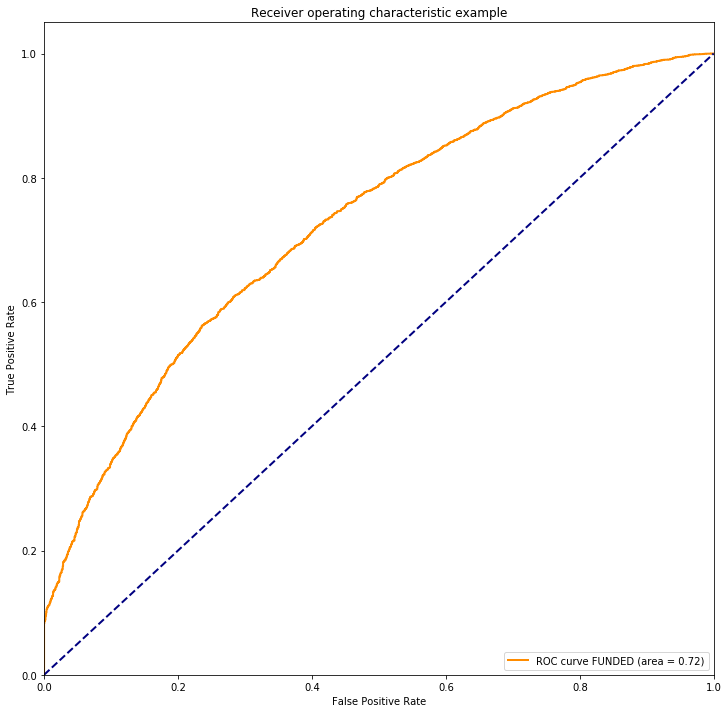

In [121]:
plt.figure(figsize=(12,12))

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve FUNDED (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('catboost_roc.png')

# Random Forest

### Fit model

In [100]:
random_forest_clf = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_features=None,
    random_state=100
)

In [101]:
random_forest_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=100, verbose=0, warm_start=False)

### Predict probability

In [106]:
y_pred_prob = random_forest_clf.predict_proba(X_test)
y_pred_prob= [value[1] for value in y_pred_prob]

In [107]:
fpr, tpr, treshold = roc_curve(y_test, y_pred_prob)

In [108]:
score = f1_score(
    y_test, 
    list(map(lambda x: 1 if x > np.mean(treshold) else 0, y_pred_prob)), 
    average='macro'
)
print(f'F1 score: {score}')

F1 score: 0.6014420083977059


In [ ]:
plt.figure(figsize=(12,12))

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve FUNDED (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('random_forest_roc.png')

# Competition data prediction

In [88]:
X_competition = competition_data.drop(columns=['RESULT'])

In [89]:
y_competition_predicted = catboost_clf.predict_proba(X_competition)

In [90]:
y_competition_predicted = list(
    map(
        lambda x: 1 if x > np.mean(treshold) else 0, 
        [value[1] for value in y_competition_predicted]
    )
)

In [91]:
competition_result['Result_Predicted'] = list(
    map(
        lambda x: 'FUNDED' if x == 1 else 'NOT FUNDED', 
        y_competition_predicted
    )
)
competition_result.to_csv('catboost_result.csv')